Prepare solution to build ticketing system there by using json file as your primary datasource (Text corpus with other metadata in it). 
1.  Group data into five categories namely Banking services, loans, Fraudalent reporting, Card, others.
2. From step 1 create labeled dataset and utilize it to train supervised model like logistic regression, decision tree or random forest.


Above excercise should follow these steps -
1. Load Data
2. Text Preprocessing
3. EDA
4. Feature Extraction
5. Topic Modelling (Unsupervised)
6. Model building using Supervised learning
7. Model Training and evaluation
8. Inference

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import re, nltk, spacy, string

In [2]:
import json

# Loading Data

In [3]:
f = open('Client_data.json')

In [4]:
data = json.load(f)

In [5]:
dataset = pd.json_normalize(data)
dataset.head(5)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [7]:
dataset['_source.complaint_what_happened'] = dataset['_source.complaint_what_happened'].astype(str)

In [8]:
dataset['_source.product'] = dataset['_source.product'].astype(str)

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [10]:
df = dataset[['_source.complaint_what_happened', '_source.product']]
df.head()

,_source.complaint_what_happened,_source.product
0,,Debt collection
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card
3,,Mortgage
4,,Credit card or prepaid card


In [11]:
df.isnull().sum()

_source.complaint_what_happened    0
_source.product                    0
dtype: int64

In [12]:
df.shape

(78313, 2)

# Text Preprocessing

In [13]:
df.rename(columns = {'_source.complaint_what_happened':'Complaint', '_source.product':'Product',
                              }, inplace = True)

C:\Users\tanmay_das1\AppData\Local\Temp\ipykernel_27816\1908717928.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns = {'_source.complaint_what_happened':'Complaint', '_source.product':'Product',


In [14]:
df.head()

,Complaint,Product
0,,Debt collection
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card
3,,Mortgage
4,,Credit card or prepaid card


In [15]:
df[df.loc[:, 'Complaint'] == ''] = np.nan

C:\Users\tanmay_das1\AppData\Local\Temp\ipykernel_27816\1784094937.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df.loc[:, 'Complaint'] == ''] = np.nan
C:\Users\tanmay_das1\AppData\Local\Temp\ipykernel_27816\1784094937.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df.loc[:, 'Complaint'] == ''] = np.nan


In [16]:
df = df[~df['Complaint'].isnull()]

In [17]:
df.shape

(21072, 2)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Complaint  21072 non-null  object
 1   Product    21072 non-null  object
dtypes: object(2)
memory usage: 493.9+ KB


In [19]:
#df['Product'].unique()

In [20]:
# Lowercasing Complaints
df['Complaint'] = df['Complaint'].str.lower()
df.head()

,Complaint,Product
1,good morning my name is xxxx xxxx and i apprec...,Debt collection
2,i upgraded my xxxx xxxx card in xx/xx/2018 and...,Credit card or prepaid card
10,chase card was reported on xx/xx/2019. however...,"Credit reporting, credit repair services, or o..."
11,"on xx/xx/2018, while trying to book a xxxx xx...","Credit reporting, credit repair services, or o..."
14,my grand son give me check for {$1600.00} i de...,Checking or savings account


In [21]:
# Lowercasing Product
df['Product'] = df['Product'].str.lower()
df.head()

,Complaint,Product
1,good morning my name is xxxx xxxx and i apprec...,debt collection
2,i upgraded my xxxx xxxx card in xx/xx/2018 and...,credit card or prepaid card
10,chase card was reported on xx/xx/2019. however...,"credit reporting, credit repair services, or o..."
11,"on xx/xx/2018, while trying to book a xxxx xx...","credit reporting, credit repair services, or o..."
14,my grand son give me check for {$1600.00} i de...,checking or savings account


In [22]:
# Removing Punctuations
df['Complaint'] = df['Complaint'].str.replace('[^A-Za-z0-9]+',' ', regex=True)
df.head()

,Complaint,Product
1,good morning my name is xxxx xxxx and i apprec...,debt collection
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,credit card or prepaid card
10,chase card was reported on xx xx 2019 however ...,"credit reporting, credit repair services, or o..."
11,on xx xx 2018 while trying to book a xxxx xxxx...,"credit reporting, credit repair services, or o..."
14,my grand son give me check for 1600 00 i depos...,checking or savings account


In [23]:
from nltk.corpus import stopwords

In [24]:
nltk.download('stopwords')
stopwords = stopwords.words('english')
stopwords.append('xxxx')
stopwords.append('xx')
stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tanmay_das1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [25]:
# Removing Stopwords
df['Complaint'] = df['Complaint'].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stopwords))
df['Product'] = df['Product'].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stopwords))
df.head()

,Complaint,Product
1,good morning name appreciate could help put st...,debt collection
2,upgraded card 2018 told agent upgrade annivers...,credit card prepaid card
10,chase card reported 2019 however fraudulent ap...,"credit reporting, credit repair services, pers..."
11,2018 trying book ticket came across offer 300 ...,"credit reporting, credit repair services, pers..."
14,grand son give check 1600 00 deposit chase acc...,checking savings account


In [26]:
df = df.sample(3000)

In [27]:
import en_core_web_sm
nlp = en_core_web_sm.load()
nltk.download('wordnet')
def lemmatize_text(text):
    sent = []
    doc = nlp(text)
    for token in doc:
        sent.append(token.lemma_)
    return " ".join(sent)
df['lemmatized_Complaint'] = df['Complaint'].apply(lemmatize_text)
df['lemmatized_Product'] = df['Product'].apply(lemmatize_text)
df.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tanmay_das1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Complaint,Product,lemmatized_Complaint,lemmatized_Product
11173,tried several times get chase correct mistakes...,mortgage,try several time get chase correct mistake get...,mortgage
430,switched paperless billing chase freedom card ...,credit card prepaid card,switch paperless billing chase freedom card du...,credit card prepay card
9046,wanted see get credit increase credit card cha...,bank account service,want see get credit increase credit card chase...,bank account service
20205,chase credit card failed resolve valid credit ...,credit card prepaid card,chase credit card fail resolve valid credit ca...,credit card prepay card
19713,bank pay home owners insurance failed make pay...,mortgage,bank pay home owner insurance fail make paymen...,mortgage


# EDA

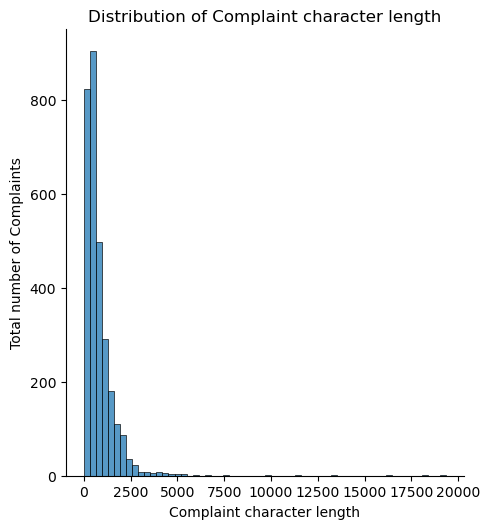

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
char_len = [len(each_sent) for each_sent in df['lemmatized_Complaint']]

sns.displot(char_len, kind='hist', bins=60)
plt.xlabel("Complaint character length")
plt.ylabel("Total number of Complaints")
plt.title("Distribution of Complaint character length")
plt.show()

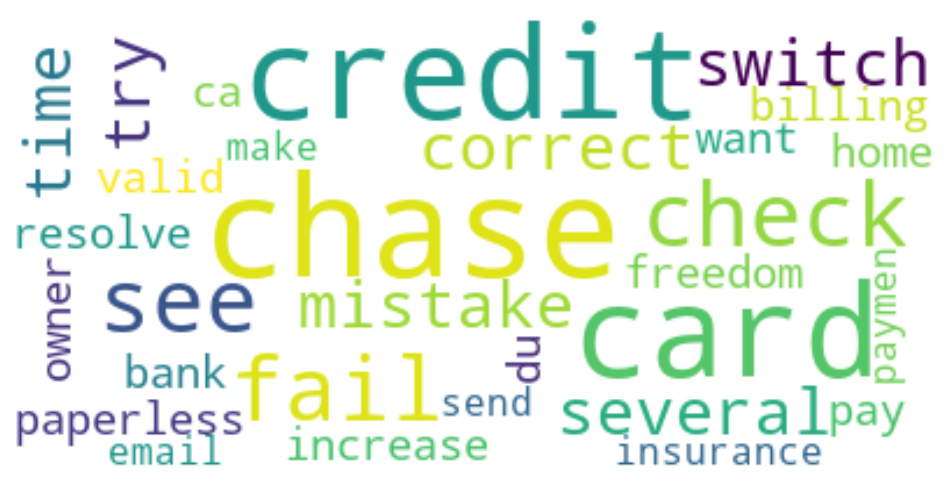

In [29]:
# Wordcloud for complaint
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=60, max_words=30, 
                      background_color="white", random_state=100, 
                      stopwords=stopwords).generate(str(df['lemmatized_Complaint']))
plt.figure(figsize=[12,12])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


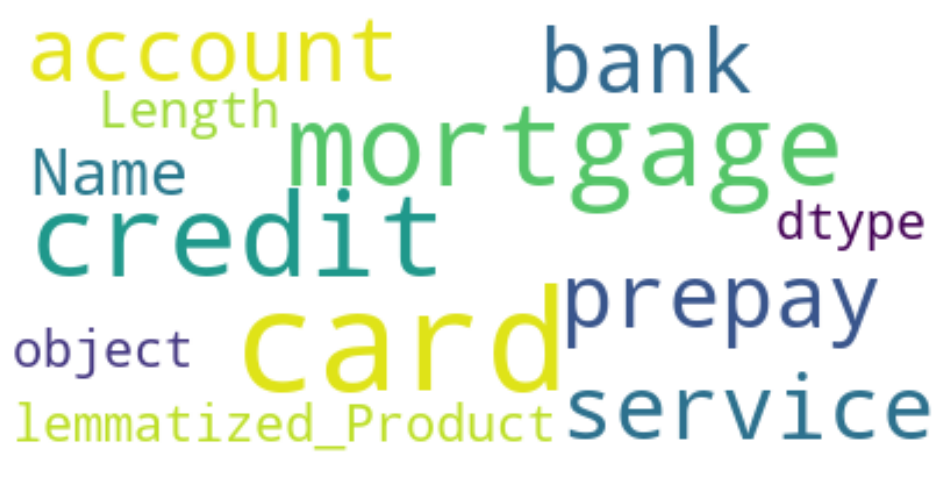

In [30]:
#wordcloud for product
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=60, max_words=30, 
                      background_color="white", random_state=100, 
                      stopwords=stopwords).generate(str(df['lemmatized_Product']))
plt.figure(figsize=[12,12])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Feature Extraction

In [31]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve
from pprint import pprint

In [32]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')

In [33]:
dtm = tfidf.fit_transform(df['lemmatized_Complaint'])

In [34]:
dtm

<3000x5467 sparse matrix of type '<class 'numpy.float64'>'
	with 175775 stored elements in Compressed Sparse Row format>

# Topic Modelling (Unsupervised)

In [35]:
from sklearn.decomposition import NMF

In [36]:
#Loading nmf_model with 5 components
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [37]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

D:\Anaconda3\envs\py39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


5467

In [38]:
H = nmf_model.components_       # Topic-term matrix

In [39]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 10)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(10)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:10]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topic 1,account,check,bank,chase,deposit,money,fund,close,tell,open
Topic 2,credit,card,report,inquiry,chase,account,remove,apply,hard,score
Topic 3,loan,mortgage,chase,modification,home,property,request,send,sale,foreclosure
Topic 4,charge,card,00,dispute,chase,fee,transaction,purchase,refund,claim
Topic 5,payment,late,pay,make,fee,balance,month,statement,00,monthly


In [40]:
#Creating the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)

In [41]:
#Assigning the best topic to each of the complaints in Topic Column
df['Topic'] = topic_results.argmax(axis=1)

In [42]:
df.head()

,Complaint,Product,lemmatized_Complaint,lemmatized_Product,Topic
11173,tried several times get chase correct mistakes...,mortgage,try several time get chase correct mistake get...,mortgage,4
430,switched paperless billing chase freedom card ...,credit card prepaid card,switch paperless billing chase freedom card du...,credit card prepay card,3
9046,wanted see get credit increase credit card cha...,bank account service,want see get credit increase credit card chase...,bank account service,1
20205,chase credit card failed resolve valid credit ...,credit card prepaid card,chase credit card fail resolve valid credit ca...,credit card prepay card,3
19713,bank pay home owners insurance failed make pay...,mortgage,bank pay home owner insurance fail make paymen...,mortgage,2


In [43]:
# Printing values in order of the topics
df.sort_values('Topic')

,Complaint,Product,lemmatized_Complaint,lemmatized_Product,Topic
65017,hi going issue going since chase closed case f...,checking savings account,hi go issue go since chase close case feel som...,check saving account,0
70590,check account chase basic account overdraft au...,bank account service,check account chase basic account overdraft au...,bank account service,0
15259,deposited 4 checks new chase savings account a...,checking savings account,deposit 4 check new chase saving account amoun...,check saving account,0
31625,mailed rent check landlord different unknown w...,checking savings account,mail rent check landlord different unknown wom...,check saving account,0
29447,hello cfpb would like bring attention harassme...,bank account service,hello cfpb would like bring attention harassme...,bank account service,0
...,...,...,...,...,...
17104,made payment chase reported late immediately m...,"credit reporting, credit repair services, pers...",make payment chase report late immediately mak...,"credit reporting , credit repair service , per...",4
61982,work last year went credit card assistance sai...,credit card,work last year go credit card assistance say 2...,credit card,4
77029,hello believe chase credit card company overch...,credit card prepaid card,hello believe chase credit card company overch...,credit card prepay card,4
44068,contacted chase bank regarding 3 credit card a...,"credit reporting, credit repair services, pers...",contact chase bank regard 3 credit card accoun...,"credit reporting , credit repair service , per...",4


In [44]:
#Create the dictionary of Topic names and Topics
Topic_names = { 0:"Banking services", 1:"Card", 2:"others", 3:"Fraudalent reporting", 4:"loans" }

#Replace Topics with Topic Names
df['Topic'] = df['Topic'].map(Topic_names)

In [45]:
df.shape

(3000, 5)

In [46]:
df.head()

,Complaint,Product,lemmatized_Complaint,lemmatized_Product,Topic
11173,tried several times get chase correct mistakes...,mortgage,try several time get chase correct mistake get...,mortgage,loans
430,switched paperless billing chase freedom card ...,credit card prepaid card,switch paperless billing chase freedom card du...,credit card prepay card,Fraudalent reporting
9046,wanted see get credit increase credit card cha...,bank account service,want see get credit increase credit card chase...,bank account service,Card
20205,chase credit card failed resolve valid credit ...,credit card prepaid card,chase credit card fail resolve valid credit ca...,credit card prepay card,Fraudalent reporting
19713,bank pay home owners insurance failed make pay...,mortgage,bank pay home owner insurance fail make paymen...,mortgage,others


# Model building using Supervised learning

We are now on the verge of building the model, for that we need to convert the topic names to numbers

In [47]:
# Again creating dictionary of Topic names and Topics
Topic_names = { "Banking services":0, "Card":1, "others":2, "Fraudalent reporting":3, "loans":4 }

# Replace Topics with Topic Names
df['Topic'] = df['Topic'].map(Topic_names)

In [48]:
training_data = df[['Complaint', 'Topic']]

In [49]:
training_data

,Complaint,Topic
11173,tried several times get chase correct mistakes...,4
430,switched paperless billing chase freedom card ...,3
9046,wanted see get credit increase credit card cha...,1
20205,chase credit card failed resolve valid credit ...,3
19713,bank pay home owners insurance failed make pay...,2
...,...,...
72279,email sent ceo consumer banking n think provid...,2
43127,discriminated chase card services credit cards...,1
29645,see complaint case number took days tell refin...,2
71782,charges 95 yearly fee exchange free checked ba...,3


Applying supervised models on the training data created

In [50]:
# code for getting the Vector count

vect = CountVectorizer()
X_train_cnt = vect.fit_transform(training_data['Complaint'])

In [51]:
# code here for transforming the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_cnt)

# Model Training and evaluation

### Decision Tree Classifier

In [52]:
from sklearn.tree import DecisionTreeClassifier

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.25, random_state=42)

In [54]:
dt = DecisionTreeClassifier(random_state=42)

In [55]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [56]:
# Getting accuracy of the model
dt.score(X_test, y_test)

0.728

In [57]:
# Making predictions on test data
y_pred = dt.predict(X_test)

In [58]:
# Printing Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[128   7  11  28   1]
 [  9  99   7   9   6]
 [  6   4 121  10  19]
 [ 16  22   9 141   9]
 [  6   5  12   8  57]]


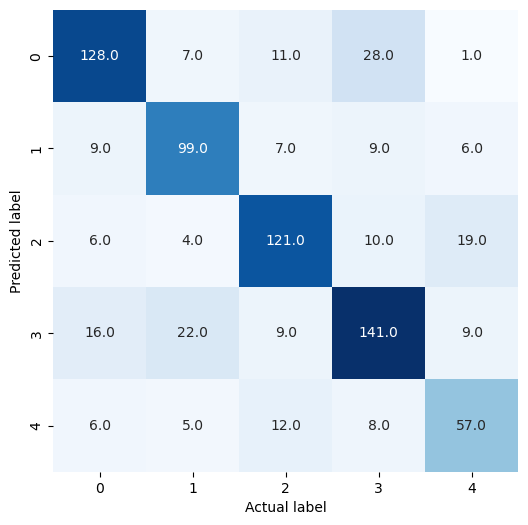

In [59]:
# Visualizing Confusion Matrix with heatmap
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                 annot=True,
                 cbar=False,
                 cmap="Blues", fmt = '0.1f')
plt.xlabel("Actual label")
plt.ylabel("Predicted label")
plt.show()

In [60]:
Topic_Names_target = ["Banking services", "Card", "others", "Fraudalent reporting", "loans"]

In [61]:
# Classification report
print(classification_report(y_test, y_pred, target_names = Topic_Names_target))

                      precision    recall  f1-score   support

    Banking services       0.78      0.73      0.75       175
                Card       0.72      0.76      0.74       130
              others       0.76      0.76      0.76       160
Fraudalent reporting       0.72      0.72      0.72       197
               loans       0.62      0.65      0.63        88

            accuracy                           0.73       750
           macro avg       0.72      0.72      0.72       750
        weighted avg       0.73      0.73      0.73       750



# Inference

Based on the algorithm implemented above, accuracy of the model is 73%, and its precision and recall, both are 72%